In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time
import numpy as np

## ***Step 1:*** Load the data

Load the json files for train and validation, into lists of texts, queries, answers

In [ ]:
path = Path('/content/drive/MyDrive/data/train-v2.0.json')

with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            if(qa['answers'] == []):
                texts.append(context)
                queries.append(question)
                answers.append({'text':'', 'answer_start':-1})
            else:
                for answer in qa['answers']:
                    texts.append(context)
                    queries.append(question)
                    answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
path = Path('/content/drive/MyDrive/data/dev-v2.0.json')

with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []
num = 0

for group in squad_dict['data']:
    for passage in group['paragraphs']:
        num += 1
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            if(qa['answers'] == []):
                texts.append(context)
                queries.append(question)
                answers.append({'text':'', 'answer_start':-1})
            else:
                for answer in qa['answers']:
                    texts.append(context)
                    queries.append(question)
                    answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

## ***Step 2:*** Data Preprocessing

Shorten the data to make it less computationally expensive

In [ ]:
train_texts = train_texts[:40000]
train_queries = train_queries[:40000]
train_answers = train_answers[:40000]

val_texts = val_texts[:5000]
val_queries = val_queries[:5000]
val_answers = val_answers[:5000]

Find end position character in train data

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the end index
    end_idx = start_idx + len(real_answer)

Find end position character in validation data

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the end index
    end_idx = start_idx + len(real_answer)

## ***Step 3:*** Tokenize queries and passages

Tokenizing using BERT-based AutoTokenizer

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_queries, train_texts, truncation=True, padding = True, return_offsets_mapping=True, return_overflowing_tokens=True)
val_encodings = tokenizer(val_queries, val_texts, truncation=True, padding = True, return_offsets_mapping=True, return_overflowing_tokens=True)

## ***Step 4:*** Convert the start-end positions to start-end tokens

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  for i, offset in enumerate(encodings["offset_mapping"]):
      sample_idx = encodings["overflow_to_sample_mapping"][i]
      answer = answers[sample_idx]
      start_char = answer["answer_start"]
      end_char = answer["answer_start"] + len(answer["text"])
      sequence_ids = encodings.sequence_ids(i)

      # Find the start and end of the context
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1

      # If the answer is not fully inside the context, label is (0, 0)
      if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
          start_positions.append(0)
          end_positions.append(0)
      else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
              idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
              idx -= 1
          end_positions.append(idx + 1)

  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

## ***Step 5:*** Create a Dataset class

Create a SQuAD dataset class to pass the inputs to the model

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, worker_init_fn=np.random.seed(seed))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2, worker_init_fn=np.random.seed(seed))

## ***Step 6:*** Use GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')


## ***Step 7:*** Creating QA model from scratch using BERT

In [ ]:
from transformers import BertModel
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

In [ ]:
class CustomModel(nn.Module):
  def __init__(self,num_labels):
    super(CustomModel,self).__init__()
    self.num_labels = num_labels

    #Load Model with given checkpoint and extract its body
    self.model= BertModel.from_pretrained('bert-base-uncased',output_attentions=True,output_hidden_states=True)
    self.second_hidden=nn.Linear(768,512)
    self.act=nn.ReLU()
    self.dropout=nn.Dropout(0.2)
    self.classifier = nn.Linear(512,num_labels) # load and initialize weights


  def forward(self, input_ids=None, attention_mask=None,start_positions=None,end_positions=None):
    #Extract outputs from the body
    sequence_output= self.model(input_ids=input_ids, attention_mask=attention_mask)

    seq=sequence_output.last_hidden_state
    seq1=self.second_hidden(seq)
    sequence_output1=self.act(seq1)
    sequence_outputs=self.dropout(sequence_output1)
    logits = self.classifier(sequence_outputs)  # Assuming this outputs a single tensor
    logits=nn.functional.softmax(logits,dim=1)

    # Split the logits into start and end logits
    start_logits, end_logits = logits[:, :, 0].squeeze(),logits[:,:,1].squeeze()
    # start_logits_ind=torch.argmax(start_logits,axis=1)
    # end_logits_ind=torch.argmax(end_logits,axis=1)

    loss = 0
    if (start_positions is not None) and (end_positions is not None):
      loss1=loss2=0
      for i in range(logits.shape[0]):
        loss1=loss1-torch.log(start_logits[i][start_positions[i]])
        loss2=loss2-torch.log(end_logits[i][end_positions[i]])
      loss = loss1 + loss2
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=sequence_output.hidden_states,attentions=sequence_output.attentions)

In [ ]:
model=CustomModel(num_labels=2).to(device)

In [ ]:
from transformers import AdamW,get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


15015


In [ ]:
from datasets import load_metric
metric = load_metric("f1")

<ipython-input-32-e4b2221a8929>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


In [ ]:
# model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
# optim = AdamW(model.parameters(), lr=5e-4)
# # optim = AdamW(model.parameters(), lr=5e-5)
# # optim = AdamW(model.parameters(), lr=5e-6)

# # epochs = 2
# epochs = 3
# # epochs = 4

## ***Step 8:*** Train and Evaluate Model

In [ ]:
epochs=3
whole_train_eval_time = time.time()

train_losses = []
val_losses = []
print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optimizer.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optimizer.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),2),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)


  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 5005 
Loss: 22.64 

Batch 2000 / 5005 
Loss: 23.35 

Batch 3000 / 5005 
Loss: 17.29 

Batch 4000 / 5005 
Loss: 16.61 

Batch 5000 / 5005 
Loss: 18.31 

############Evaluate############

-------Epoch  1 -------
Training Loss: 23.48715936599316 
Validation Loss: 24.436480738095927 
Time:  4009.7379331588745 
----------------------- 


############Train############
Batch 1000 / 5005 
Loss: 13.47 

Batch 2000 / 5005 
Loss: 30.62 

Batch 3000 / 5005 
Loss: 7.2 

Batch 4000 / 5005 
Loss: 12.23 

Batch 5000 / 5005 
Loss: 11.45 

############Evaluate############

-------Epoch  2 -------
Training Loss: 13.577309691489159 
Validation Loss: 29.410927769573984 
Time:  4006.398639678955 
----------------------- 


############Train############
Batch 1000 / 5005 
Loss: 11.72 

Batch 2000 / 5005 
Loss: 15.62 

Batch 3000 / 5005 
Loss: 9.78 

Batch 4000 / 5005 
Loss: 11.53 

Batch 5000 / 5005 
Loss: 6.83 

############Evaluate############

-------Epoch  3 ---

In [ ]:
# Save model
torch.save(model,"/content/drive/MyDrive/data/sc_40k_d_5")

## ***Step 12:*** Plot train and validation losses

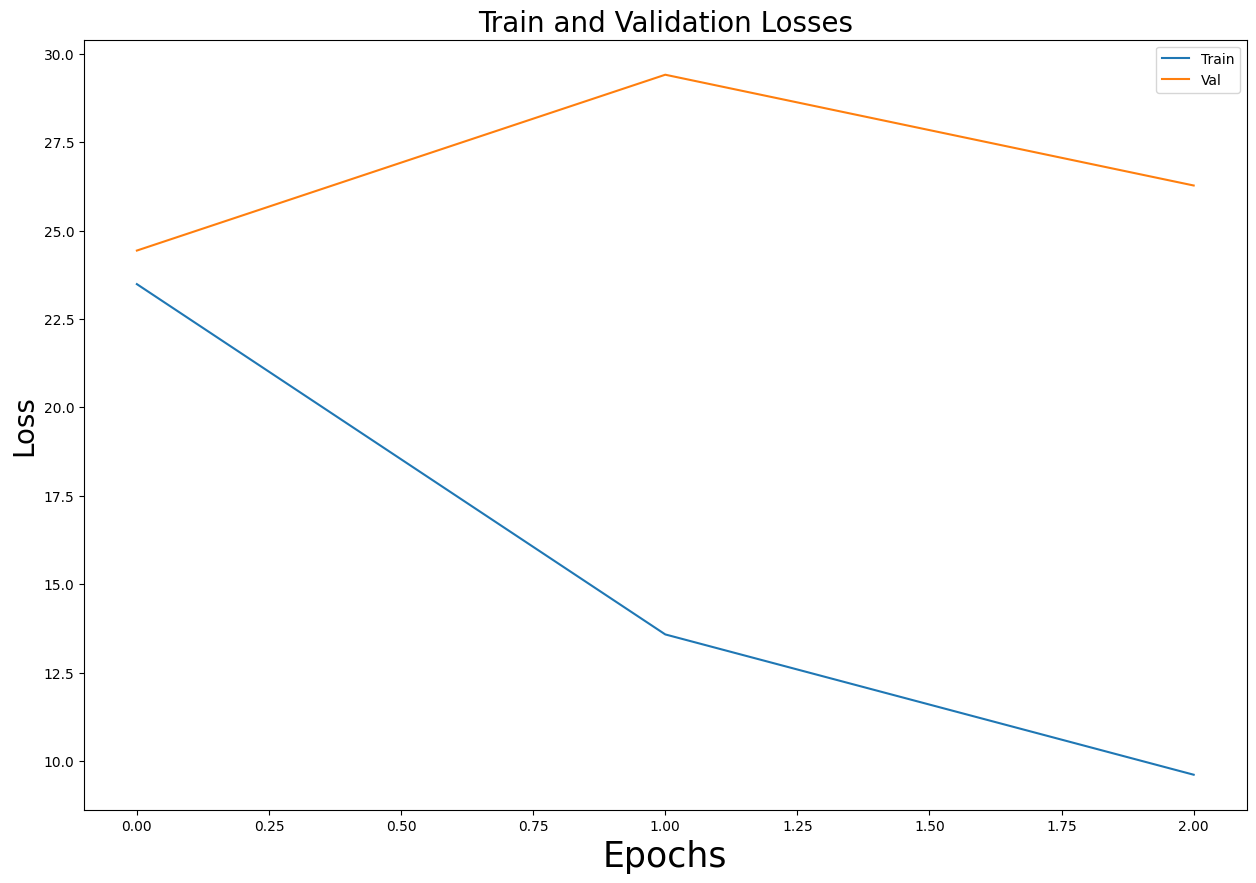

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

plt.savefig("/content/drive/MyDrive/data/EVL/sc_40k_5_d.png")